![Banner del curso](https://docs.google.com/uc?export=download&id=1v9oXzOC5J_zT3_QLaVC47qIy67U1CO6b)

#Inferencia sobre los datos

Este notebook es la recopilacion de todos los temas vistos de la parte teorica para el de analisis de datos. Lo principal es ir a poco a poco viendo la aplicacion de estos conceptos en lo que hemos visto. Los datos con los que vamos a trabajar corresponden a datos entregados por el Instituto Nacional de Salud (SIVIGILA) de Colombia y contiene los datos de las enfermedades en el area de Santander.

# Importacion de elementos

### Importacion de librerias necesarias

In [0]:
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
from IPython.display import clear_output
from IPython.display import HTML
warnings.filterwarnings('ignore')
%matplotlib inline

### Importacion de los datos al computador

In [0]:
# Descargo los datos en mi maquina virtual
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1i3tbN08QrLAfGY-RHNhYhJbSeuzi7jHp' -O data_salud.xlsx
clear_output()

df = pd.read_excel('data_salud.xlsx')

In [3]:
df.columns

Index(['cod_eve', 'grupo', 'fec_not', 'semana', 'año', 'cod_pre', 'cod_sub',
       'repet', 'grupo etario', 'grupo edad', 'Ciclo de vida', 'sexo_',
       'cod_pais_o', 'cod_dpto_o', 'cod_mun_o', 'codigomunicipio', 'area_',
       'localidad_', 'cen_pobla_', 'vereda_', 'bar_ver_', 'Comuna',
       'ocupacion_', 'tip_ss_', 'cod_ase_', 'aseguradora', 'per_etn_',
       'gp_discapa', 'gp_desplaz', 'gp_migrant', 'gp_carcela', 'gp_gestan',
       'gp_indigen', 'gp_pobicbf', 'gp_mad_com', 'gp_desmovi', 'gp_psiquia',
       'gp_vic_vio', 'gp_otros', 'cod_dpto_r', 'cod_mun_r', 'fec_con_',
       'ini_sin_', 'tip_cas_', 'pac_hos_', 'fec_hos_', 'con_fin_', 'fec_def_',
       'ajuste_', 'cer_def_', 'cbmte_', 'uni_modif', 'nuni_modif',
       'fec_arc_xl', 'nit_upgd', 'fm_fuerza', 'fm_unidad', 'fm_grado',
       'version', 'nom_eve', 'nom_upgd', 'ndep_proce'],
      dtype='object')

In [59]:
report = pp.ProfileReport(df)
report.to_file(outputfile="Datos_iniciales_salud.html")
HTML(filename='Datos_iniciales_salud.html')

Number of variables,62
Number of observations,14238
Total Missing (%),12.8%
Total size in memory,6.7 MiB
Average record size in memory,496.0 B
Numeric,30
Categorical,20
Boolean,5
Date,4
Text (Unique),0
Rejected,2


In [5]:
df.isna().sum()

cod_eve           0
grupo             0
fec_not           0
semana            0
año               0
              ...  
fm_grado      14153
version           0
nom_eve           0
nom_upgd          0
ndep_proce        0
Length: 62, dtype: int64

In [6]:
df.isna().sum().values.sum()

128044

In [16]:
#Rellenado de la columna repet
indices = []
for i in range(len(df["repet"])):
  if np.isnan(df.at[i, "repet"]):
    df.at[i,"repet"] = np.random.choice([0,1],1)
df["repet"].isna().sum()

0

In [21]:
for i in range(len(df["codigomunicipio"])):
  if df.at[i, "codigomunicipio"] in [681, 680, 68001]:
    df.at[i, "codigomunicipio"] = 68001
  elif df.at[i, "codigomunicipio"] in [124, 1105, 1850]:
    df.at[i, "codigomunicipio"] = 1850
  else:
    df.at[i, "codigomunicipio"] = np.random.choice([68001, 1850],1)
df["codigomunicipio"].isna().sum()

0

In [0]:
for i in range(len(df["localidad_"])):
  if df["cen_pobla_"].isna().values[i]:
    df.at[i, "cen_pobla_"] = df.at[i, "localidad_"]

In [58]:
for i in range(len(df["localidad_"])):
  if df.at[i, "localidad_"] in ['NO APLICA', 'NO SABE', 'NA|', 
                                'SIN INFORMACION','NO HAY DATO','DESCONOCIDO', 'SIN DATO', 
                                'SIIN DATO','NO INFORMA','NAA', 'NO APLIC', 'N   A', 'N  A',
                                'N A','NA3','NO APLIA','NOI APLICA','NO  APLICA','NMA', 
                                'NIO APLICA','N', 'NO APICA', 'NO APLICO','NAS','MA',
                                'NO APLIOCA','99999999999999999999', '68001','001', 
                                'NO REGISTRA', '99999999','NO AP´LCIA'] or type(df.at[i, "localidad_"]) == int:
    df.at[i, "localidad_"] = 'SIN INFORMACION'
  else:
    df.at[i, "localidad_"] = 'URBANA'
df["localidad_"].isna().sum()

0

In [0]:
#Ejecutar solamente si vas a convertir las columnas con fechas en 3 columnas nuevas

#Convertir las columnas de fechas en 3 columnas nuevas
columnas = df.dtypes[df.dtypes == 'datetime64[ns]'].index.tolist() #para cuando las columnas estan definidas en tipo de fecha
for columna in columnas:
  df['{}_year'.format(columna)] = df[columna].dt.year
  df['{}_month'.format(columna)] = df[columna].dt.month
  df['{}_day'.format(columna)] = df[columna].dt.day
  df.drop(columna, axis=1, inplace=True)

In [0]:
#Convertir el tipo de dato de cada celda de una columna a valores conocidos
for i in range(df.shape[0]):
  df.at[i,"fec_hos_"] = str(df.at[i,"fec_hos_"])

#### LabelEncoder
Consiste en convertir cada valor diferente de una columna a un numero empezando desde 0. Para mas informacion sobre este metodo puede referirse a la [documentacion del LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [66]:
#Transformar una columna unitaria
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df["Ciclo de vida"])
le.classes_ = ['Primera infancia', 'Infancia','Adolescencia', 'Jovenes','Adultez', 'Persona Mayor']
df["Ciclo de vida"] = le.transform(df["Ciclo de vida"])
df.head()

,cod_eve,grupo,semana,año,cod_pre,cod_sub,repet,grupo etario,grupo edad,Ciclo de vida,sexo_,cod_pais_o,cod_dpto_o,cod_mun_o,codigomunicipio,area_,localidad_,cen_pobla_,vereda_,bar_ver_,Comuna,ocupacion_,tip_ss_,cod_ase_,aseguradora,per_etn_,gp_discapa,gp_desplaz,gp_migrant,gp_carcela,gp_gestan,gp_indigen,gp_pobicbf,gp_mad_com,gp_desmovi,gp_psiquia,gp_vic_vio,gp_otros,cod_dpto_r,cod_mun_r,tip_cas_,pac_hos_,fec_hos_,con_fin_,fec_def_,ajuste_,cer_def_,cbmte_,uni_modif,nuni_modif,nit_upgd,fm_fuerza,fm_unidad,fm_grado,version,nom_eve,nom_upgd,ndep_proce,fec_not_year,fec_not_month,fec_not_day,fec_con__year,fec_con__month,fec_con__day,ini_sin__year,ini_sin__month,ini_sin__day,fec_arc_xl_year,fec_arc_xl_month,fec_arc_xl_day
0,210,ENFERMEDADES TRANSMITIDAS POR VECTORES,1,2015,6800100431,1,0.0,10 a 14,7 a 11,1,M,170,68,1,68001.0,1,URBANA,URBANA,NaN,LAGOS DEL CACIQUE,16 LAGOS DEL CACIQUE,9997,C,EPS130,EPS COLSANITAS,6,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,68,1,2,1,2015-01-04 00:00:00,1,- -,3,NaN,NaN,6.800100e+11,CLINICA MATERNO INFANTIL SAN LUIS SA,8.902088e+09,NaN,NaN,NaN,SIVIGILA - 2015 - 15.1.0,DENGUE,CLINICA MATERNO INFANTIL SAN LUIS SA,SANTANDER,2015,1,4,2015,1,4,2015,1,4,2016,1,15
1,210,ENFERMEDADES TRANSMITIDAS POR VECTORES,1,2015,6800101628,3,0.0,20 a 29,18 a 28,3,F,170,68,1,68001.0,1,URBANA,URBANA,NaN,CABECERA DEL LLANO,12 CABECERA DEL LLANO,9997,C,EPS002,SALUD TOTAL S.A. E.P.S.,6,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,68,1,2,2,- -,1,- -,0,NaN,NaN,NaN,NaN,8.001309e+09,NaN,NaN,NaN,SIVIGILA - 2015 - 15.1.0,DENGUE,SALUD TOTAL SA UUBC,SANTANDER,2015,1,5,2015,1,5,2015,1,4,2016,1,15
2,210,ENFERMEDADES TRANSMITIDAS POR VECTORES,1,2015,5400100470,1,0.0,15 a 19,12 a 17,2,M,170,68,1,68001.0,1,URBANA,BUCARAMANGA,NaN,QUINTA DANIA,13 ORIENTAL,9997,C,EPS037,NUEVA EPS,6,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,68,1,2,2,- -,1,- -,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SIVIGILA - 2014 - 14.2.0,DENGUE,RETROALIMENTACIÓN,SANTANDER,2015,1,5,2015,1,4,2015,1,2,2016,1,15
3,210,ENFERMEDADES TRANSMITIDAS POR VECTORES,1,2015,6800101366,2,0.0,30 a 39,29 a 59,4,F,170,68,1,68001.0,1,URBANA,BUCARAMANGA,NaN,VILLA ROSA,1 NORTE,2226,C,EPS013,SALUDCOOP E.P.S.,6,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,68,1,2,2,- -,1,- -,6,NaN,NaN,6.800101e+11,IPS COOMULTRASAN SEDE VII,8.902011e+09,NaN,NaN,NaN,SIVIGILA - 2015 - 15.1.0,DENGUE,IPS COOMULTRASAN SEDE II,SANTANDER,2015,1,6,2015,1,6,2015,1,4,2016,1,15
4,210,ENFERMEDADES TRANSMITIDAS POR VECTORES,1,2015,6800101666,16,0.0,30 a 39,29 a 59,4,M,170,68,1,68001.0,1,URBANA,NaN,NaN,LOS COLORADOS,1 NORTE,7129,C,EPS037,NUEVA EPS,6,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,68,1,2,2,- -,1,- -,0,NaN,NaN,NaN,NaN,8.902054e+09,NaN,NaN,NaN,SIVIGILA - 2015 - 15.1.0,DENGUE,FUNDACION OFTALMOLOGICA DE SANTANDER- SEDE BUC...,SANTANDER,2015,1,7,2015,1,5,2015,1,4,2016,1,15


In [67]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_label_encoder = np.zeros(df.shape)
for i in range(len(df.columns)):
  try:
    df_label_encoder[:,i] = le.fit_transform(df[df.columns[i]])
  except:
    columna = df[df.columns[i]].values
    strings = []
    numeros = []
    for j in columna:
      if type(j) == str:
        strings.append(j)
      else:
        numeros.append(j)
    strings = np.r_[strings]
    numeros = np.r_[numeros].astype(np.float32)
    columna = np.append(strings, numeros)
    df_label_encoder[:,i] = le.fit_transform(columna)

df_label_encoder = pd.DataFrame(df_label_encoder, columns=df.columns)
df_label_encoder.head()

,cod_eve,grupo,semana,año,cod_pre,cod_sub,repet,grupo etario,grupo edad,Ciclo de vida,sexo_,cod_pais_o,cod_dpto_o,cod_mun_o,codigomunicipio,area_,localidad_,cen_pobla_,vereda_,bar_ver_,Comuna,ocupacion_,tip_ss_,cod_ase_,aseguradora,per_etn_,gp_discapa,gp_desplaz,gp_migrant,gp_carcela,gp_gestan,gp_indigen,gp_pobicbf,gp_mad_com,gp_desmovi,gp_psiquia,gp_vic_vio,gp_otros,cod_dpto_r,cod_mun_r,tip_cas_,pac_hos_,fec_hos_,con_fin_,fec_def_,ajuste_,cer_def_,cbmte_,uni_modif,nuni_modif,nit_upgd,fm_fuerza,fm_unidad,fm_grado,version,nom_eve,nom_upgd,ndep_proce,fec_not_year,fec_not_month,fec_not_day,fec_con__year,fec_con__month,fec_con__day,ini_sin__year,ini_sin__month,ini_sin__day,fec_arc_xl_year,fec_arc_xl_month,fec_arc_xl_day
0,1.0,0.0,0.0,0.0,139.0,1.0,0.0,1.0,7.0,1.0,1.0,3.0,1.0,1.0,1.0,0.0,1.0,424.0,6.0,592.0,8.0,445.0,0.0,58.0,55.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,14.0,1.0,1.0,0.0,1.0,1.0,0.0,12.0,32.0,10.0,75.0,17.0,42.0,187.0,199.0,198.0,1.0,2.0,44.0,1.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,3.0
1,1.0,0.0,0.0,0.0,152.0,3.0,0.0,3.0,3.0,3.0,0.0,3.0,1.0,1.0,1.0,0.0,1.0,424.0,59.0,205.0,3.0,445.0,0.0,35.0,89.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,14.0,1.0,1.0,1.0,0.0,1.0,0.0,12.0,9483.0,10.0,2924.0,41.0,19.0,9414.0,9426.0,9425.0,1.0,2.0,85.0,1.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,3.0
2,1.0,0.0,0.0,0.0,120.0,1.0,0.0,2.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,0.0,1.0,79.0,3.0,875.0,4.0,445.0,0.0,51.0,82.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,14.0,1.0,1.0,1.0,0.0,1.0,0.0,12.0,9484.0,2.0,2949.0,47.0,99.0,9415.0,9427.0,9426.0,0.0,2.0,82.0,1.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,3.0
3,1.0,0.0,0.0,0.0,149.0,2.0,0.0,4.0,5.0,4.0,0.0,3.0,1.0,1.0,1.0,0.0,1.0,79.0,0.0,1153.0,0.0,71.0,0.0,41.0,94.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,14.0,1.0,1.0,1.0,0.0,1.0,0.0,12.0,9485.0,9.0,89.0,29.0,35.0,9416.0,9428.0,9427.0,1.0,2.0,72.0,1.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,3.0
4,1.0,0.0,0.0,0.0,154.0,16.0,0.0,4.0,5.0,4.0,1.0,3.0,1.0,1.0,1.0,0.0,1.0,79.0,22.0,626.0,0.0,290.0,0.0,51.0,82.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,14.0,1.0,1.0,1.0,0.0,1.0,0.0,12.0,9486.0,1.0,2950.0,17.0,40.0,9417.0,9429.0,9428.0,1.0,2.0,58.0,1.0,0.0,0.0,6.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,3.0


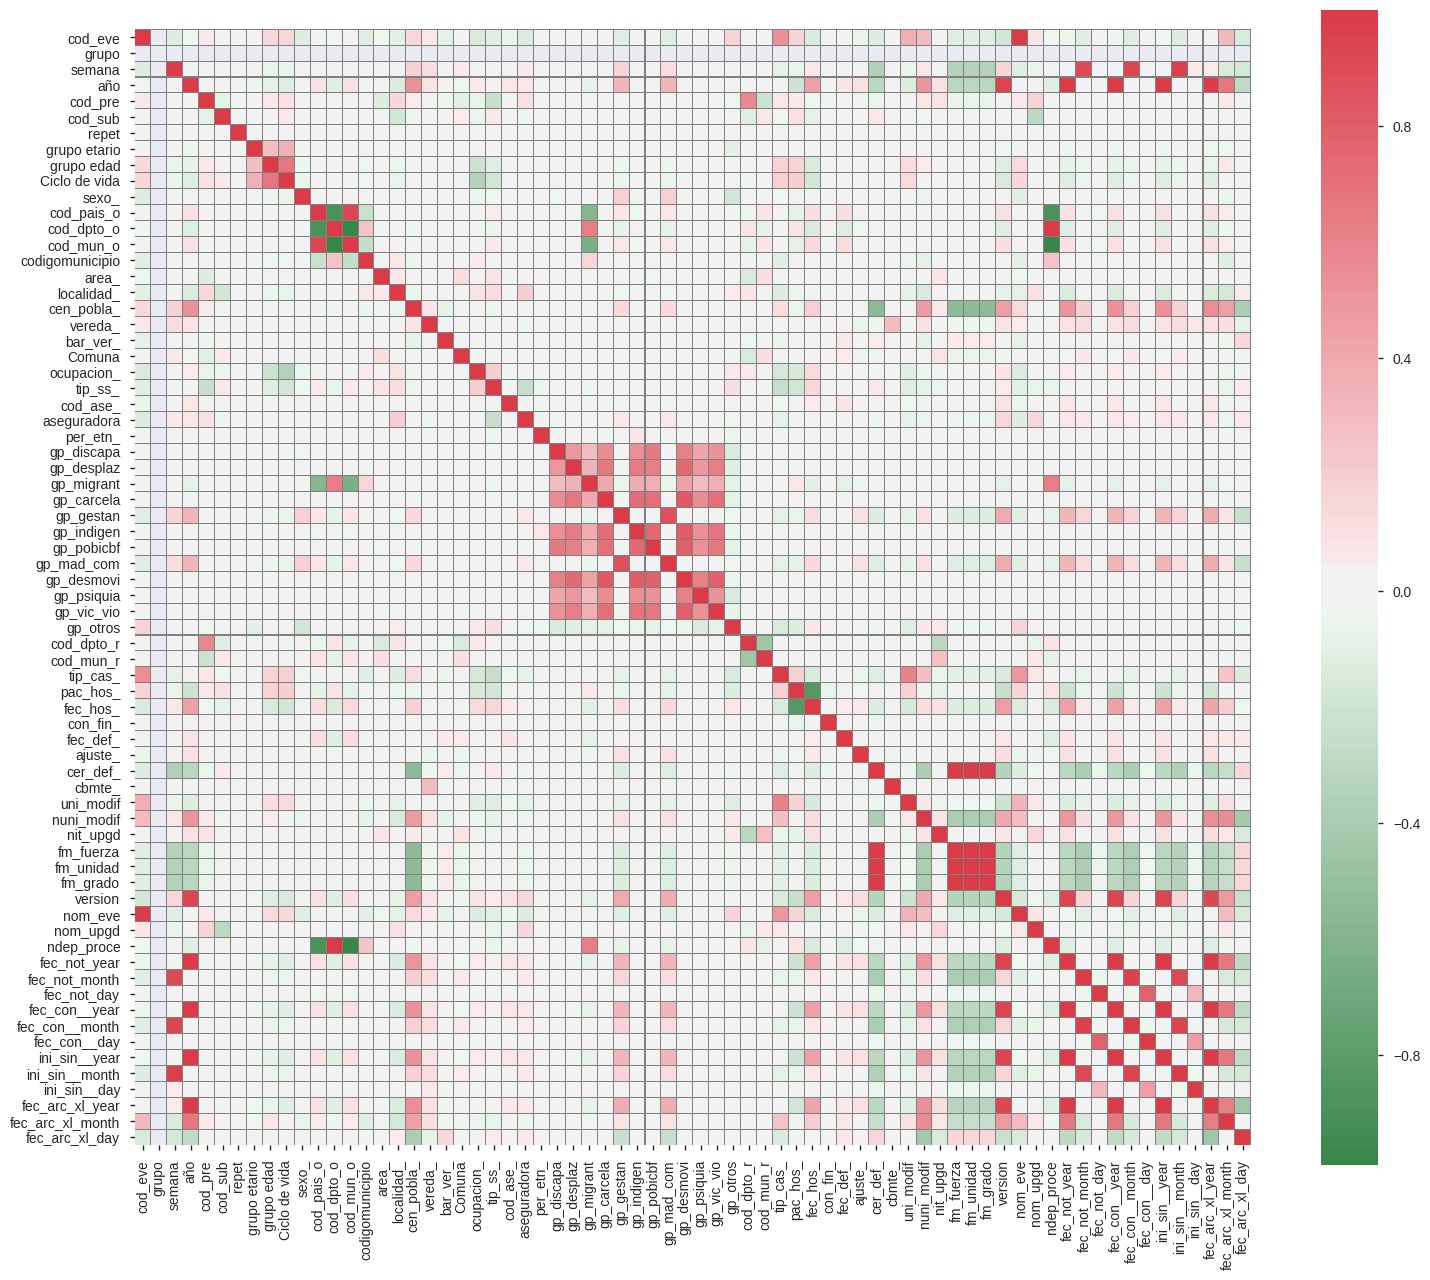

In [68]:
#correlation matrix
corrmat = df_label_encoder.corr()
f, ax = plt.subplots(figsize=(18,15))
color = sns.diverging_palette(133, 10, as_cmap=True)
sns.heatmap(corrmat, square=True, cmap=color, annot=False, linecolor='grey', linewidths=0.01);

### Estudio univariable
En esta parte ahora si nos vamos a enfocar en estudiar las relaciones de la variable dependiente con las variables que dejamos al final de la primera inferencia.

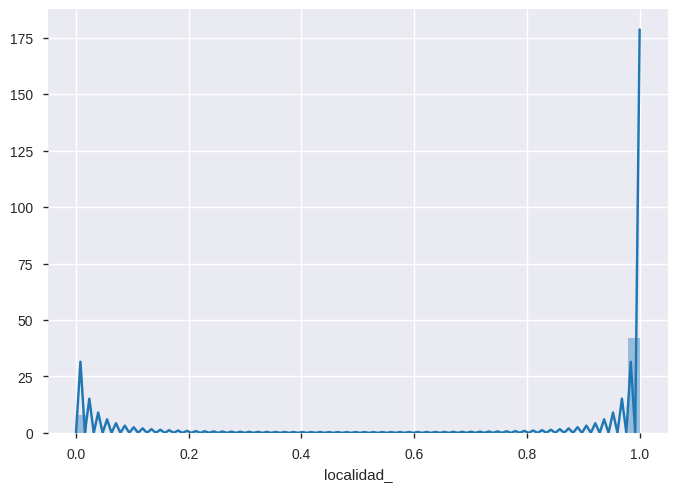

In [76]:
#Visualizacion de la distribucion de nuestra variable
sns.distplot(df_label_encoder['localidad_']);

In [0]:
#Asimetria y curtosis de la distribucion para saber que tan gordita y asimetrica esta
print("Asimetria: %f" % df_label_encoder['nom_eve'].skew())
print("Curtosis: %f" % df_label_encoder['nom_eve'].kurt())

Asimetria: 0.802804
Curtosis: -1.305710


#### Relaciones con nuestra seleccion de variables

##### Relaciones con variables numericas

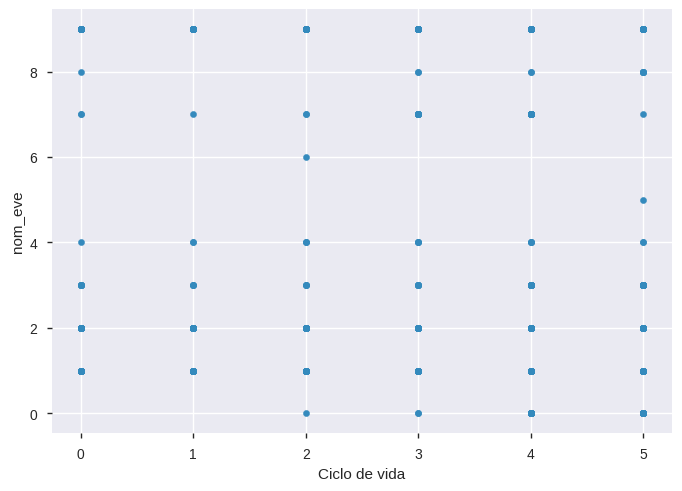

In [73]:
#scatter plot
var = 'Ciclo de vida' #Aqui va el nombre de la variable que vamos a comparar
data = pd.concat([df_label_encoder['nom_eve'], df_label_encoder[var]], axis=1)
data.plot.scatter(x=var, y='nom_eve');

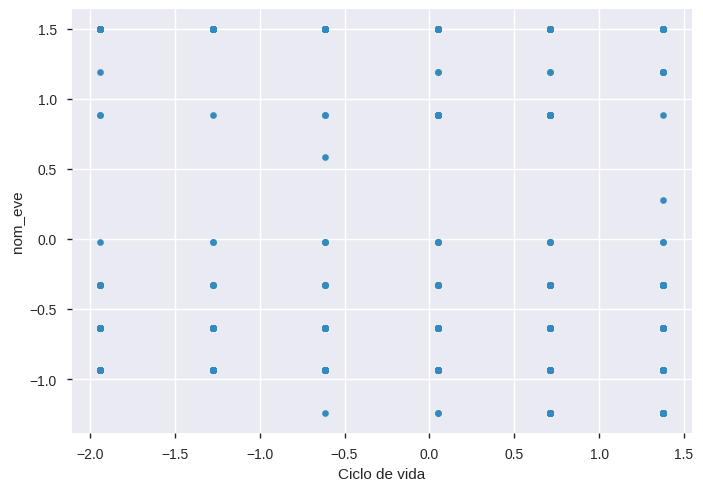

In [74]:
from sklearn.preprocessing import StandardScaler

escalador = StandardScaler()

data_normalizado = escalador.fit_transform(data)
data_normalizado = pd.DataFrame(data_normalizado, columns = data.columns)
data_normalizado.plot.scatter(x=var, y='nom_eve');

#### Conclusiones de la revision univariable
Luego de que graficaras y vieras las relaciones de todas las variables que escojiste con la variable principal.

**¿Que podemos concluir?**

### Estudio multivariable
A diferencia del paso anterior, en esta parte no nos enfocamos en una variable sino en llegar a comparar todas con todas.

#### Grafica de todos contra todos

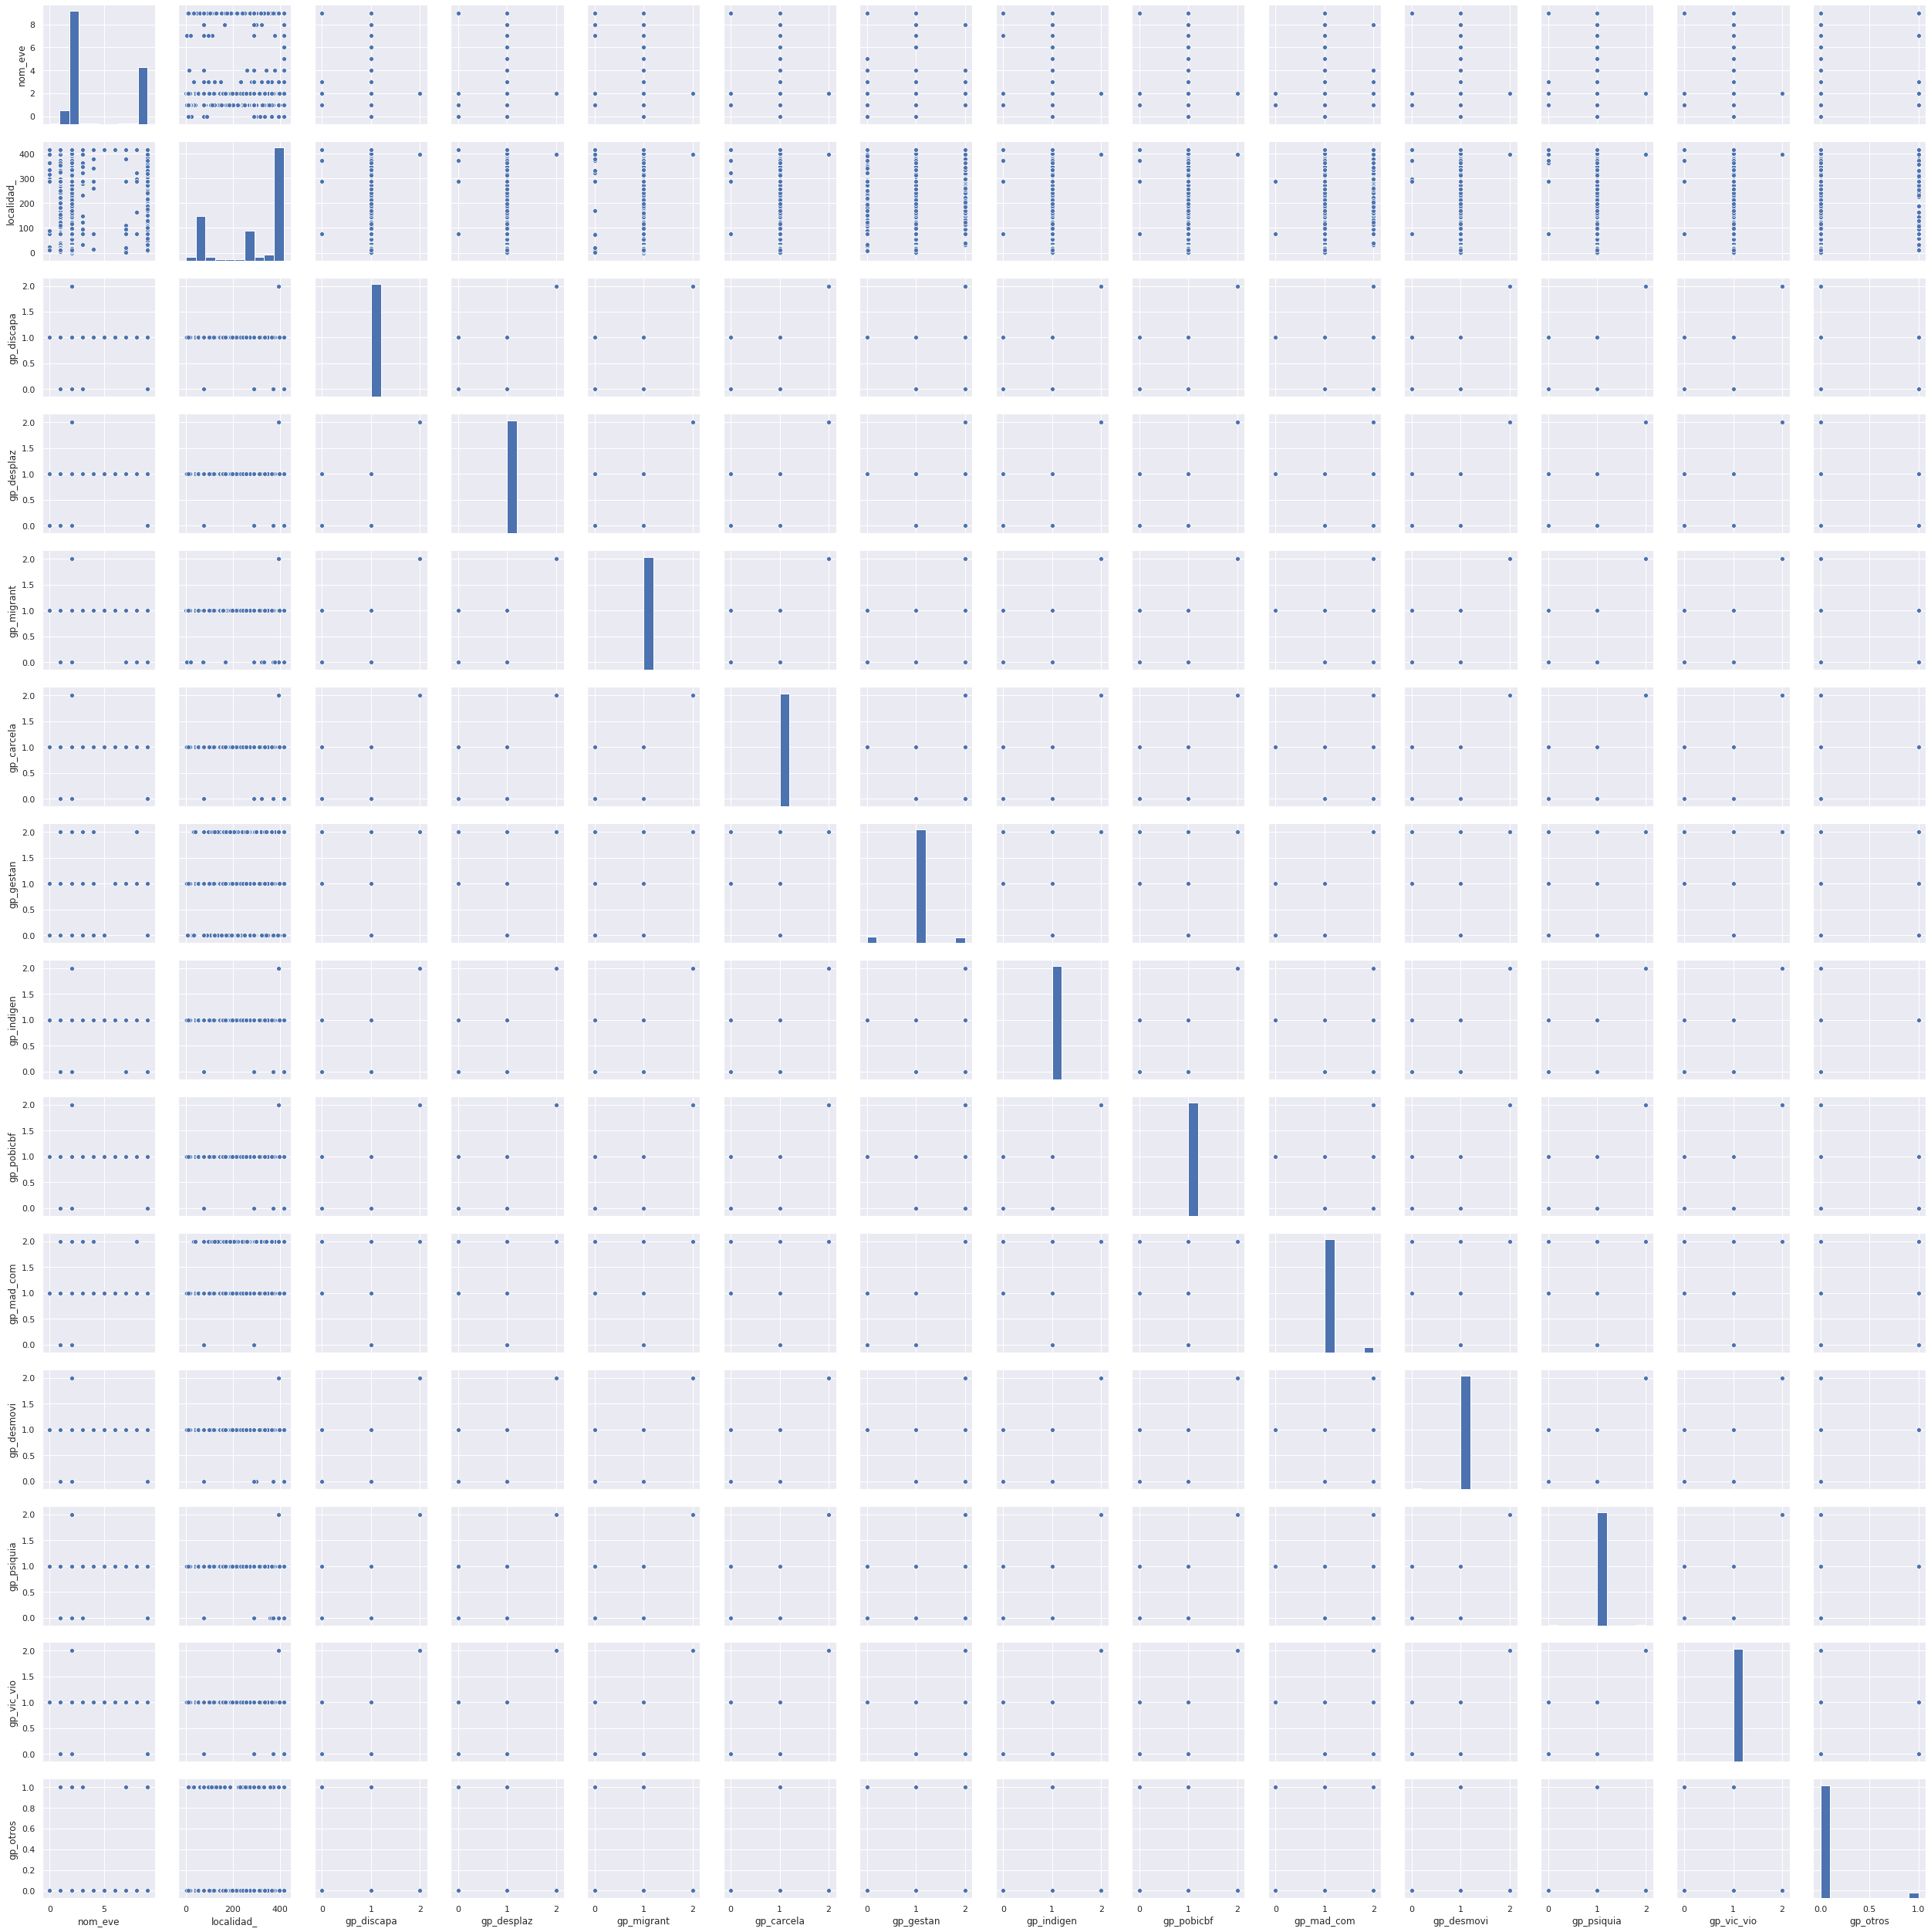

In [0]:
#scatterplot
sns.set()
cols = ['nom_eve', 'localidad_', 'gp_discapa', 'gp_desplaz', 'gp_migrant', 'gp_carcela', 'gp_gestan',
       'gp_indigen', 'gp_pobicbf', 'gp_mad_com', 'gp_desmovi', 'gp_psiquia',
       'gp_vic_vio', 'gp_otros'] # Aqui ponemos todas las variables que escojimos
sns.pairplot(df_label_encoder[cols], size = 2.5)
plt.show();

# Referencia

- [Analisis exploratorio de Datos de House Pricing Dataset](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)
- [Analisis exploratorio de Datos de Titanic Dataset](https://github.com/masumrumi/Titanic_Kaggle)
- [Codificaciones sobre los datos con Scikit-Learn](https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621)
- [Agrupaciones de datos con Scikit-Learn](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02)
